**Importing Necessary Libraries**

In [1]:
# Utility
import numpy as np
import pandas as pd
import pickle

# Plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

**Importing Data**

In [4]:
df = pd.read_csv('/kaggle/input/cyberbulling-tweets/cyberbullying_tweets.csv')

In [5]:
display(df.sample(5))

,tweet_text,cyberbullying_type
24506,@vappywave idiot that's not gonna work. you go...,other_cyberbullying
13677,I hate Fox News because they will change what ...,gender
42872,So you think it's disgusting how blacks are tr...,ethnicity
8520,RT @ChloeSeashell: Not a fan of this comic (to...,gender
8776,"Rape is not a joke, I don't care if you're gay...",gender


In [6]:
df.shape

(47692, 2)

In [7]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [8]:
for tweet in df.sample(5)['tweet_text']:
    print(tweet +'\n')

I appreciate all of the emails regarding the domain WHOIS info, but rest assured, this was deliberate.

so i'm not wearing makeup and dasia didn't know and she goes "are you sick?" BITCH

@JillWetzler WHERE IS THIS WEDDING I AM CRASHING IT

Just know that I’m no longer sharing videos of whites barring Black people from entering the Black persons home or pool. Barge past them, continue about your day, and tell the property. If they don’t do anything about it, THEN you tell social media so we can bully a termination

He acts like a high school bully. He does not belong in government. #GymJordan



In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [10]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


**Data Pre-processing**

In [11]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [12]:
df['tweet_text'].duplicated().sum()

1675

In [13]:
df.drop_duplicates('tweet_text', inplace=True, ignore_index=True)

In [14]:
df['tweet_text'].duplicated().sum()

0

In [15]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: count, dtype: int64

In [16]:
# df = df[df["cyberbullying_type"] != "other_cyberbullying"]
# df['cyberbullying_type'].unique()

In [17]:
from sklearn.utils import resample

# Find the minimum class count (other_cyberbullying: 6243)
min_samples = 6243

# Undersample all classes to match the minority class
df = df.groupby('cyberbullying_type', group_keys=False).apply(lambda x: x.sample(n=min_samples, random_state=42))

# Verify class distribution
print(df['cyberbullying_type'].value_counts())

cyberbullying_type
age                    6243
ethnicity              6243
gender                 6243
not_cyberbullying      6243
other_cyberbullying    6243
religion               6243
Name: count, dtype: int64


We are undersampling the majority classes to match the minority class (6243 samples per class) to create a balanced dataset, preventing model bias and avoiding data duplication for fair learning and better generalization. 


In [18]:
cyberbullying_type = ['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity', 'other_cyberbullying']
encoding_dict = {'not_cyberbullying':0, 'gender':1, 'religion':2, 'age':3, 'ethnicity':4, 'other_cyberbullying':5}
df['cyberbullying_type'] = df['cyberbullying_type'].map(encoding_dict)

In [19]:
df.sample(10)

,tweet_text,cyberbullying_type
32219,This may lead to social anxiety where one of s...,3
20174,"Not all hindus voted them,or at least not beca...",2
33528,I had 'Free' dinner tickets. To let other pupi...,3
24802,#BlameOneNotAll http://t.co/gZ2HfYIlhx,5
33510,I was never bullied in school. Maybe like one ...,3
19900,"If you consider your self a communist, you’re ...",2
38101,"@tayyoung_: FUCK OBAMA, dumb ass nigger You ma...",4
32481,Just found videos of me aged 4! My sisters bul...,3
44576,@A_Ramsey253 @Bamaloc fuck both of u dumb ass ...,4
28271,RT @ItsShake4ndbake: Damn just checked and my ...,5


Time to clean the tweets and process them to a new column

In [20]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
stopwords_list = stopwords.words('english')
additional_stopwords = ['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's']   # Specific to twitter lingo
stopwords_list.extend(additional_stopwords)
lemmatizer = WordNetLemmatizer()    # Using Lemmatizer instead of Stemmer

Below are the custom defined functions to deep clean the unprocessed tweets.
Their identifier names describe their working.

In [22]:
def remove_usernames(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='@']
    return ' '.join(words)

def remove_hashtags(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='#']
    return ' '.join(words)

def remove_links(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[:4]!='http']
    return ' '.join(words) 

def remove_punctuation(tweet):
    for mark in punctuation:
        tweet = tweet.replace(mark, '')
    return tweet

def convert_lowercase(tweet):
    return tweet.lower()

def tokenization(tweet):
    return word_tokenize(tweet)

def remove_stopwords(tok_tweet):
    res = []
    for word in tok_tweet:
        if word not in stopwords_list:
            res.append(word)
    return res

def lemmatize_words(tok_tweet):
    res = []
    for word in tok_tweet:
        res.append(lemmatizer.lemmatize(word))
    return res

In [23]:
# Defining a custom tweet cleaning function
def pre_processing_custom(tweet):
    tweet = remove_usernames(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_links(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

Time to apply this processing function to our dataset.

In [24]:
df['clean_tweets'] = df['tweet_text'].map(pre_processing_custom)

In [25]:
df.sample(10)

,tweet_text,cyberbullying_type,clean_tweets
44075,"Then negro again , then black the. African Ame...",4,negro black african american 1989 back black o...
4438,@a_man_in_black WHY AM I NOT ON THE LIST,0,list
22497,Hahaha how cheap some journalists go just to m...,2,hahaha cheap journalist go mke muslim better t...
11370,Her ideas aren’t acknowledging misogynistic pa...,1,idea ’ acknowledging misogynistic patriarchal ...
14975,"Jovan can u address how, when people make joke...",1,jovan address people make joke male rape contr...
39656,No one is going to listen in Bihar. Every pers...,4,one going listen bihar every person conscience...
22105,@CapehartJ why is it every time some idiot whi...,2,every time idiot white person f fault every wh...
36316,This girl tried to say we were friends in high...,3,girl tried say friend high school ’ bullied
37796,It was an anti-bullying song I wrote after tak...,3,antibullying song wrote taking high school mus...
11226,RT @bonedagger: @MT8_9 @TheNewKidd3 @charenton...,1,men actually die dv suicide result factored pe...


The **clean_tweets** column holds the processed tweets.

It's nice and does the job, but we can do much better cleaning by using pre-defined functions and RegEx.
Therefore, I'm using the **tweet-preprocessor** library, as shown below.

In [26]:
!pip install tweet-preprocessor
import preprocessor as p

In [27]:
def clean_tweets(tweet):
    tweet = p.clean(tweet)
    return tweet

It takes care of all the URLs, Hashtags, Mentions, Reserved Words, Emojis and Smileys.

In [28]:
# Defining the better cleaning function
def pre_processing(tweet):
    tweet = clean_tweets(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

In [29]:
# Clean tweets
df['clean_tweets'] = df['tweet_text'].map(pre_processing)
df.sample(10)

,tweet_text,cyberbullying_type,clean_tweets
20495,@dankmtl Load of BS. Their numbers fell steadi...,2,load b number fell steadily since youre still ...
39507,"Unfollow me if u support trump, racism, or if ...",4,unfollow support trump racism think white pers...
11627,"i can't believe ella would say the ""n"" word, j...",1,cant believe ella would say word joke rape use...
39402,"they talking bout a riot today , cause its the...",4,talking bout riot today cause last day school ...
11542,@The_Last_Ride1 Exactly. Thor is really not t...,1,exactly thor really reinvent female daredevil ...
118,The girls need to learn how to churn #MKR,0,girl need learn churn
14125,@FF_XIV_EN 2/2 Ultros thanalan shout could use...,1,2 ultros thanalan shout could use gming remove...
39017,Racism is wen u select ur white clothes 2 wash...,4,racism wen select white clothes wash first b4 ...
22344,"Idiot,I’m not a muslim!!but basically you must...",2,idiotim muslimbut basically must know power re...
7403,I didn't really love Katie and Nikki to begin ...,0,didnt really love katie nikki begin really pre...


Checking again if any values got duplicated.

In [30]:
df['clean_tweets'].duplicated().sum()

1407

Removing them all.

In [31]:
df.drop_duplicates('clean_tweets', inplace=True, ignore_index=True)
df['clean_tweets'].duplicated().sum()

0

In [32]:
df.shape

(36051, 3)

**36051** tweets are remaining.

Now that we have processed the tweets, it's time to move forward and calculate the total and average word lengths of each tweet.

In [33]:
# Total word count of a tweet
df['word_count'] = df['tweet_text'].map(lambda x: len(x.split()))
df.sample(10)

,tweet_text,cyberbullying_type,clean_tweets,word_count
27695,I hate people who say I got this. In all hones...,5,hate people say got honesty dont damn thing,17
2210,Funny how the girls who bullied me in middle&a...,3,funny girl bullied middleamp high school told ...,39
19109,Too. Much. Pause. For. Effect. Pete. Evans. Ju...,0,much pause effect pete evans annoyingnot dramatic,12
31691,@CherguiaMbark @Nebula1979 I'm not interested ...,2,interested sectarian division shia sunni follo...,19
9593,http://t.co/VyZeWBzBuF,4,,1
3684,I recently got to know that the girl who heavi...,3,recently got know girl heavily bullied high sc...,56
30266,Qouting quran without it's background is the t...,2,qouting quran without background technique use...,22
35175,Hi Jazeera Suppose an African Christian woman ...,2,hi jazeera suppose african christian woman dis...,45
7280,"Shane Dawson molested his cat, called people n...",4,shane dawson molested cat called people nigger...,34
19982,#IfIRuledTheWorld Nobody Would Be Bullied #Rea...,0,nobody would bullied,6


In [34]:
# Average word length of a tweet
def avg_word_length(tweet):
    words = tweet.split()
    word_count = len(words)
    word_length = 0
    for word in words:
        word_length += len(word)
    avg_length = round(word_length / word_count,2)
    return avg_length

df['avg_word_length'] = df['tweet_text'].map(avg_word_length)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets,word_count,avg_word_length
5780,Lol right! I was bullied in middle school so I...,3,lol right bullied middle school spent high sch...,52,4.37
33083,@RichardDawkins The fact that there were two l...,2,fact two layer evil dealt iraq doesnt mean lef...,24,4.42
11521,"“@tayyoung_: FUCK OBAMA, dumb ass nigger” the ...",4,fuck obama dumb as nigger ignorance today yout...,15,5.00
15297,"me: oh man, this new rapper is really goo- new...",1,oh man new rapper really goo new rapper gay jo...,27,4.19
1159,i just know i’m gonna see at least 4 girls fro...,3,know gon na see least girl high school bullied...,32,3.75


**Data Visualization**

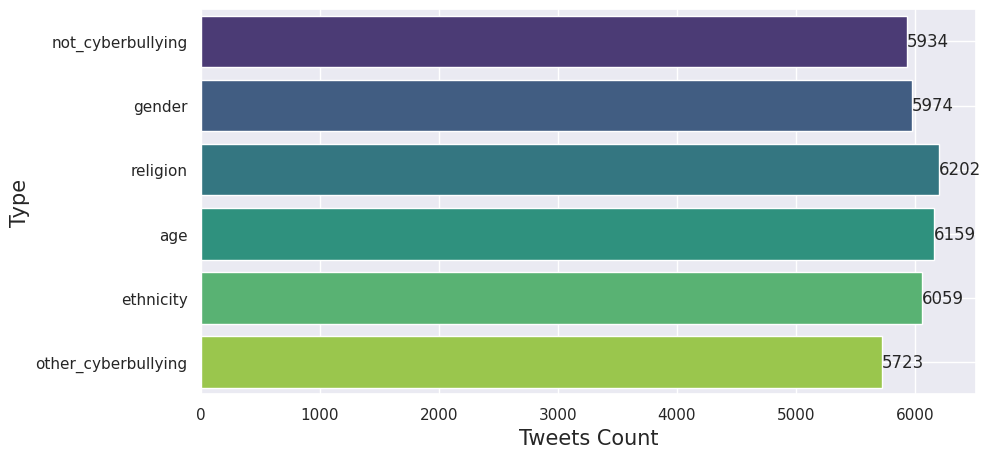

In [36]:
sns.set_theme()
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, y='cyberbullying_type', palette="viridis")
ax.bar_label(ax.containers[0])
plt.yticks(ticks=[0,1,2,3,4,5], labels=cyberbullying_type)
plt.xlabel('Tweets Count', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

All the classes look balanced.

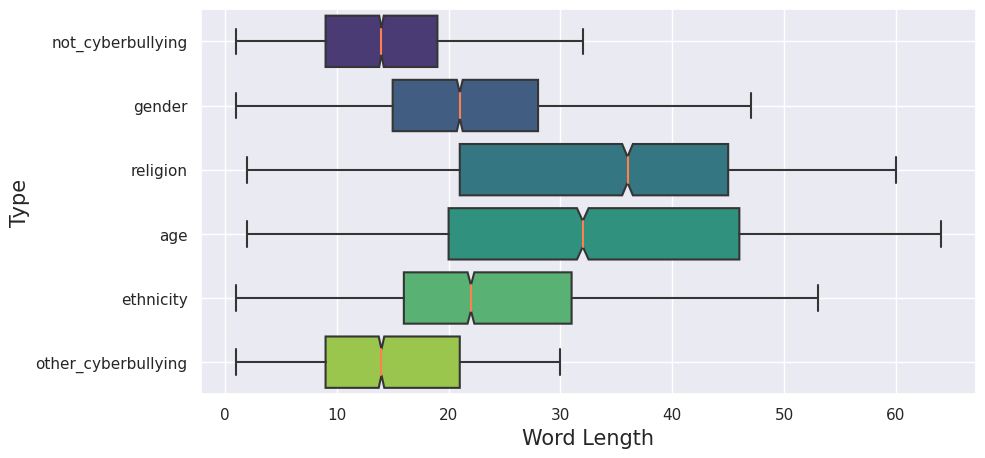

In [37]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='cyberbullying_type', x='word_count', orient='h', showfliers=False, palette='viridis', notch=True, medianprops={"color": "coral"})
plt.yticks(ticks=[0,1,2,3,4,5], labels=cyberbullying_type)
plt.xlabel('Word Length', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

We can observe that the tweets targeted towards a gender tend to have a bit less words in them than say, the ones targeted towards religion.
But overall, a bullying tweet has more words in it and is more varied than a normal one.

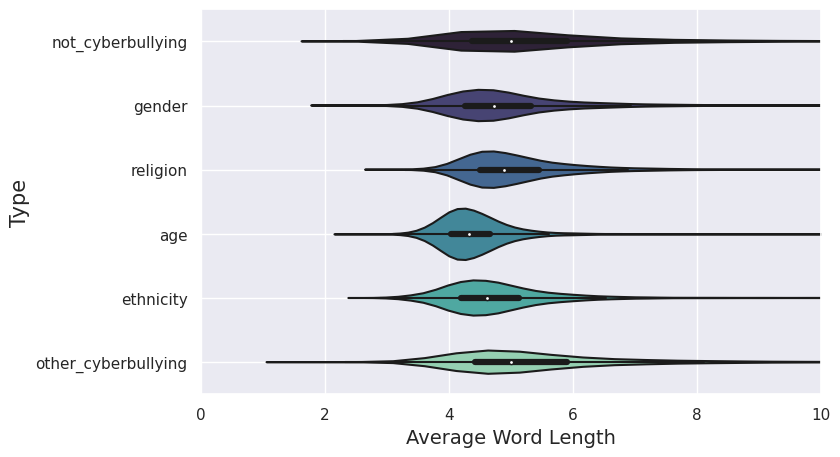

In [38]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, y='cyberbullying_type', x='avg_word_length', orient='h', palette='mako')
plt.xlim(0, 10)
plt.yticks(ticks=[0,1,2,3,4,5], labels=cyberbullying_type)
plt.xlabel('Average Word Length', size=14)
plt.ylabel('Type', size=15)
plt.grid(color='w')

Pretty much the same for all, between 4 to 6 letters.

Text(32.0, 0.5, 'Average Word Length')

<Figure size 800x500 with 0 Axes>

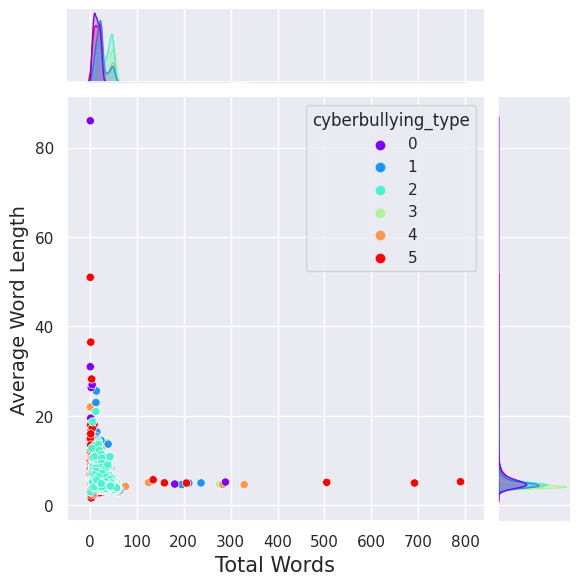

In [39]:
plt.figure(figsize=(8, 5))
sns.jointplot(data=df, y='avg_word_length', x='word_count', hue='cyberbullying_type', palette='rainbow')
plt.xlabel('Total Words', size=15)
plt.ylabel('Average Word Length', size=14)

**Word clouds**

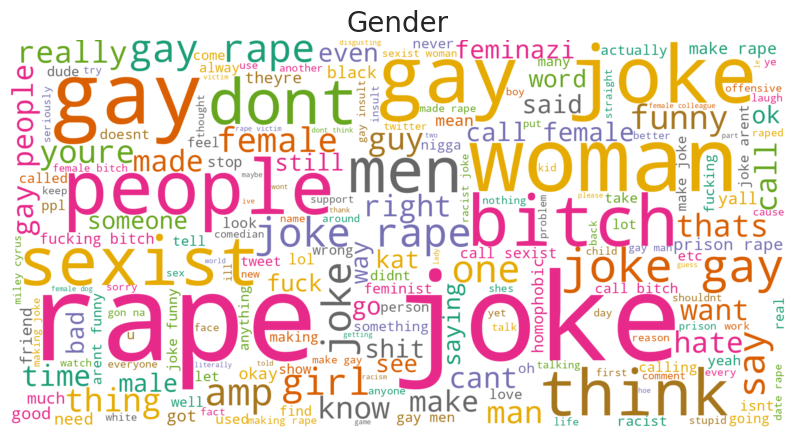

In [40]:
# Gender
plt.figure(figsize=(10, 10))
subset1 = df[df['cyberbullying_type']==1]
text_gender = subset1['clean_tweets'].values
wc1 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_gender))

plt.axis('off')
plt.title("Gender", fontsize=20)
plt.imshow(wc1, interpolation='bilinear')

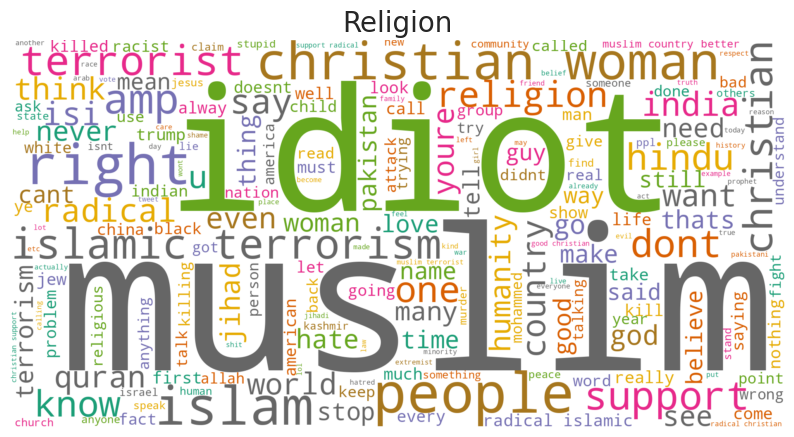

In [41]:
# Religion
plt.figure(figsize=(10, 10))
subset2 = df[df['cyberbullying_type']==2]
text_religion = subset2['clean_tweets'].values
wc2 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_religion))

plt.axis('off')
plt.title("Religion", fontsize=20)
plt.imshow(wc2, interpolation='bilinear')

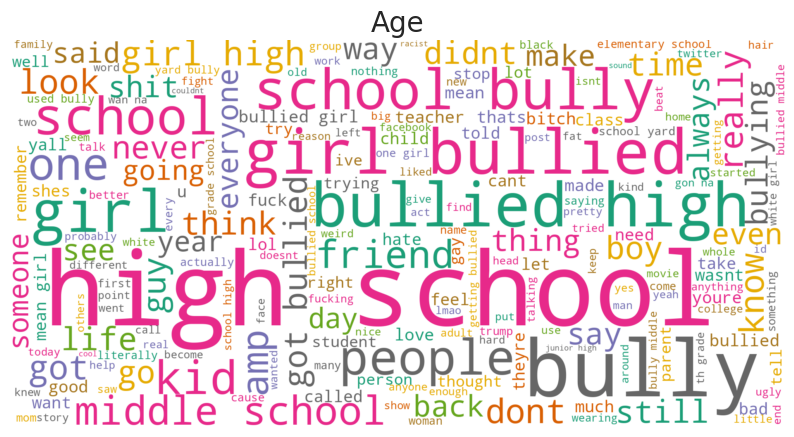

In [42]:
# Age
plt.figure(figsize=(10, 10))
subset3 = df[df['cyberbullying_type']==3]
text_age = subset3['clean_tweets'].values
wc3 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_age))

plt.axis('off')
plt.title("Age", fontsize=20)
plt.imshow(wc3, interpolation='bilinear')

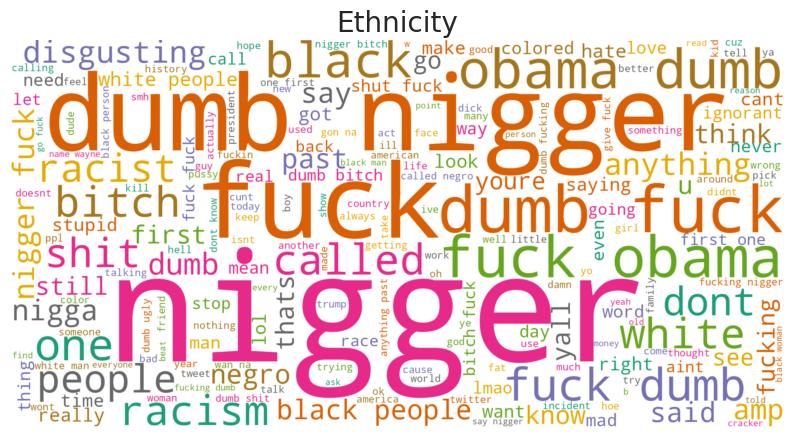

In [43]:
# Ethnicity
plt.figure(figsize=(10, 10))
subset4 = df[df['cyberbullying_type']==4]
text_ethnicity = subset4['clean_tweets'].values
wc4 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_ethnicity))

plt.axis('off')
plt.title("Ethnicity", fontsize=20)
plt.imshow(wc4, interpolation='bilinear')

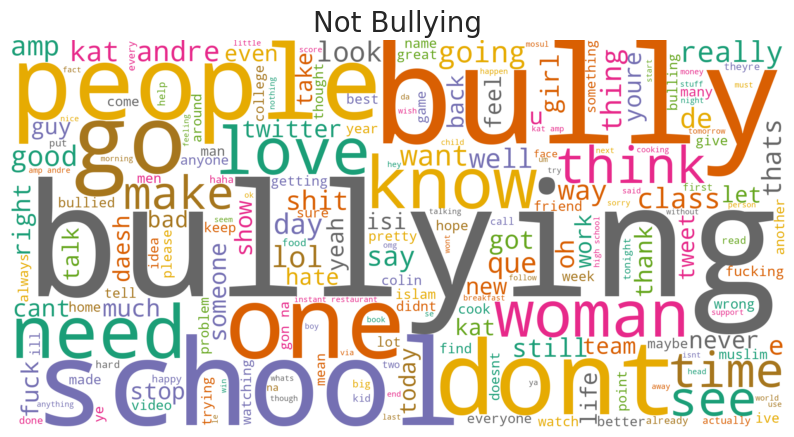

In [44]:
# Not Bullying
plt.figure(figsize=(10, 10))
subset0 = df[df['cyberbullying_type']==0]
text_not = subset0['clean_tweets'].values
wc0 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_not))

plt.axis('off')
plt.title("Not Bullying", fontsize=20)
plt.imshow(wc0, interpolation='bilinear')

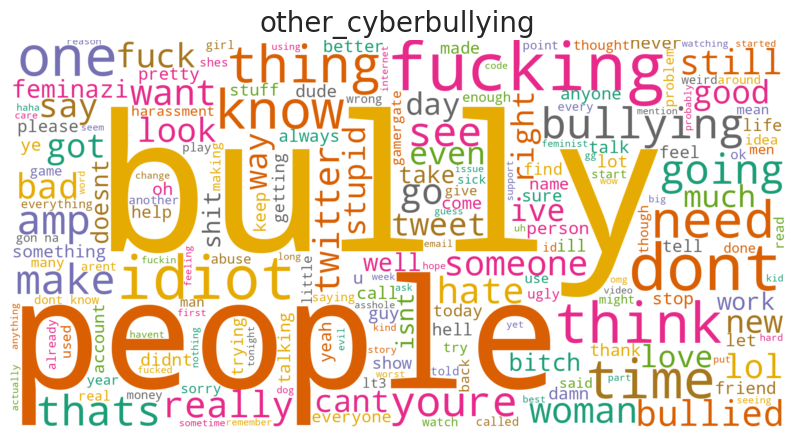

In [51]:
# other_cyberbullying
plt.figure(figsize=(10, 10))
subset5 = df[df['cyberbullying_type']==5]
text_other = subset5['clean_tweets'].values
wc5 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_other))

plt.axis('off')
plt.title("other_cyberbullying", fontsize=20)
plt.imshow(wc5, interpolation='bilinear')

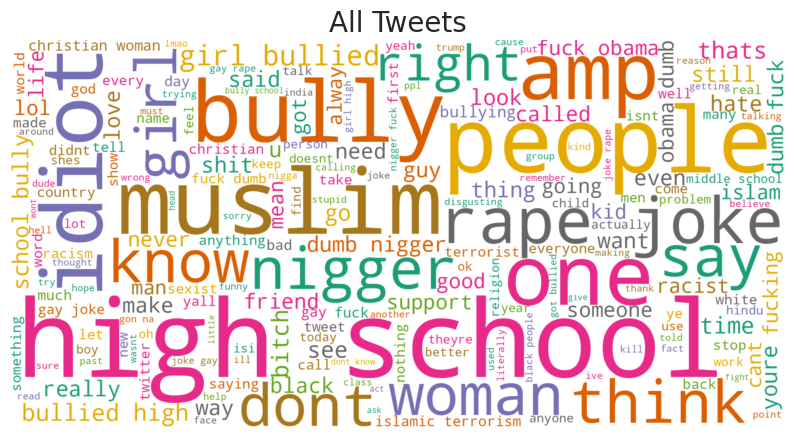

In [52]:
# All Tweets
plt.figure(figsize=(10, 10))
text_all = df['clean_tweets'].values
wc = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_all))

plt.axis('off')
plt.title("All Tweets", fontsize=20)
plt.imshow(wc, interpolation='bilinear')

Now that we're done with the wordclouds, let's check which words are the most popular.

In [53]:
from collections import Counter   # To count the frequency of each word

temp=[]
for tweet in df['clean_tweets']:
  for word in tweet.split():
    temp.append(word)
vocab = Counter(temp)
print("Vocabulary Size:", len(vocab))
print(list(vocab.items())[:5])

Vocabulary Size: 35963
[('every', 722), ('single', 167), ('one', 2856), ('girl', 4287), ('would', 1625)]


**vocab** contains the frequency of all the unique words in the whole dataset. Pretty interesting.
Let's try to plot it and see what we get.

In [54]:
common_word=[]
freq=[]
for i, j in vocab.most_common()[:10]:
  common_word.append(i)
  freq.append(j)

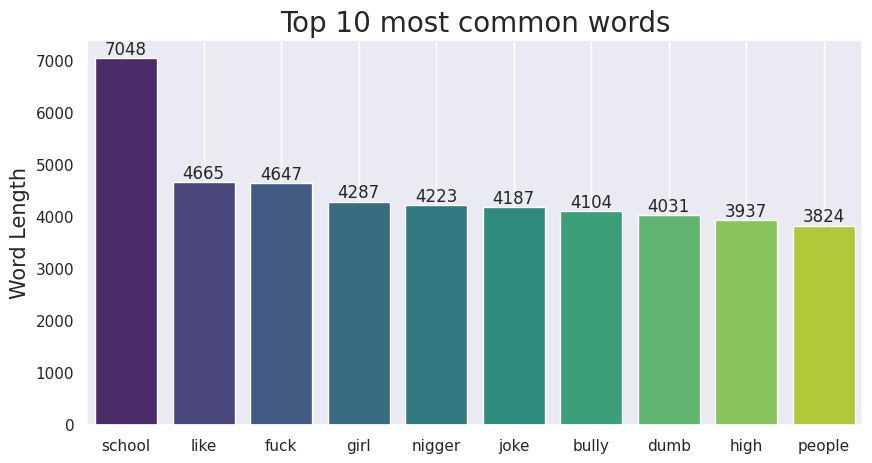

In [55]:
# Most common words
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=common_word, y=freq, palette='viridis')
plt.title('Top 10 most common words', size=20)
ax.bar_label(ax.containers[0])
plt.ylabel("Word Length", size=15)
plt.grid()

In [56]:
df

,tweet_text,cyberbullying_type,clean_tweets,word_count,avg_word_length
0,Every single one is a girl that would have bul...,3,every single one girl would bullied high school,14,4.00
1,that post ab kpop stans going to school togeth...,3,post ab kpop stans going school together every...,30,4.40
2,"Because some people have nothing better to do,...",3,people nothing better bully school never outgrew,20,4.30
3,Bro I coach JV this past year at Skyline....Br...,3,bro coach jv past year skylinebro team could g...,54,4.17
4,These ladies really do remind me of the high s...,3,lady really remind high school chickswith bull...,22,4.86
...,...,...,...,...,...
36046,"@BDSSupporter Who cares where they were born, ...",2,care born camel breath call israeli jew,15,5.67
36047,If being a Muslim didn't stop you from calling...,2,muslim didnt stop calling woke christian shoul...,45,4.53
36048,Oh good. A Christian woman shows up to throw i...,2,oh good christian woman show throw insult righ...,26,4.15
36049,If I really care? You simple in the head? If I...,2,really care simple head really care muslim mai...,44,4.30


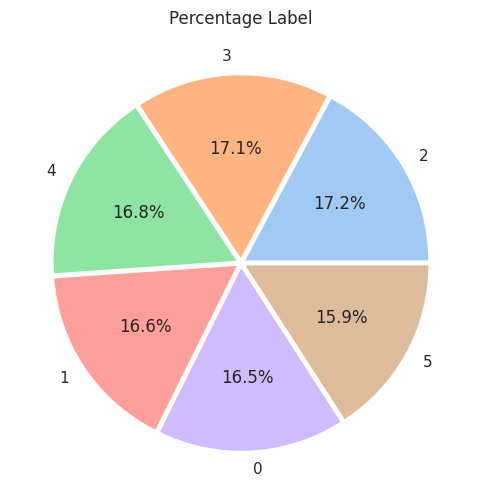

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

label_count = df['cyberbullying_type'].value_counts()

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02] * len(label_count)

plt.figure(figsize=(10, 6))
plt.pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
plt.title('Percentage Label')
plt.show()

**Named Entity Recognition (NER) Plot**

In [58]:
import spacy
from spacy import displacy

In [59]:
#sample text
text = df['tweet_text'].iloc[4]

#load pre-trained NER model
nlp = spacy.load('en_core_web_sm')

#perform named entity recognition
doc = nlp(text)

#visualize named entities
displacy.render(doc, style='ent', jupyter=True)

**Part-of-Speech (POS) Tagging Plot**

In [60]:
#sample text
text = df['tweet_text'].iloc[1]

#load pre-trained POS tagging model
nlp = spacy.load('en_core_web_sm')

#perform POS tagging
doc = nlp(text)

#visualize POS tagging
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})